# Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import shutil
import torch

from torchvision.transforms import Compose, ToTensor, RandomCrop, RandomRotation, Resize, Normalize
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

First, we are preparing the data for the ImageFolder Class of torchvision.

In [8]:
def prepare_data_for_ImageFolder(data_train=['train'], label_name='train.csv'):
    """
    Prepare the data to fullfil the requirements of ImageFolder Class of torchvision.
    
    """
    # Set the data directory
    home_dir = os.getcwd()
    data_train_folder = data_train
    train_data_dir = os.path.join(home_dir, *data_train_folder)

    label_file_name = label_name
    labels_file_dir = os.path.join(home_dir, data_train_folder[0], label_file_name)
    print(labels_file_dir)
    labels = pd.read_csv(labels_file_dir, header=0)
    
    # Search if there are lose files
    onlyfiles = [f for f in os.listdir(train_data_dir) if os.path.isfile(os.path.join(train_data_dir, f))]
    if len(onlyfiles) == 0:
        return train_data_dir
    
    # For each image
    for idx, whale_info in tqdm(labels.iterrows()):
        # Get data
        whale_img, whale_id = whale_info[0], whale_info[1]
        whale_id_dir = os.path.join(train_data_dir, whale_id)

        # Check if directory exists
        if not os.path.exists(whale_id_dir):
            os.makedirs(whale_id_dir)

        # Moves file to the id folder
        file_path = os.path.join(train_data_dir, whale_img)
        shutil.move(file_path, whale_id_dir)
    
    return train_data_dir
data_train = ['humpback-whale-identification', 'train']
train_data_folder = prepare_data_for_ImageFolder(data_train=data_train)

D:\ARQUIVOS PESSOAIS\GitHub\Humpback Whale Identification\humpback-whale-identification\train.csv


25361it [03:15, 129.62it/s]


In [46]:
# Created dataset
train_data_dir = train_data_folder

transforms = Compose([Resize((500, 1000)),
                      RandomCrop((400, 800)),
                      RandomRotation(15),
                      ToTensor(),
                      Normalize((.485, .456, .406), (.229, .224, .225))
])

whale_data = ImageFolder(train_data_dir, transform=transforms)
data_loader = DataLoader(whale_data,
                         batch_size=4,
                         shuffle=True,
                         num_workers=3)

Check an image and the label from the dataloader

w_e726a9c


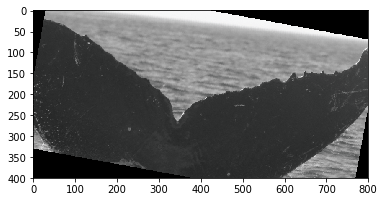

In [47]:
def imshow(img, ax):
    std = np.array([.229, .224, .225]).reshape(3,1,1)
    mean = np.array([.485, .456, .406]).reshape(3,1,1)
    img = img * std + mean # unnormalize
    img = np.clip(img, 0, 1)
    ax.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# Check data
img, label = iter(data_loader).next()
fig, ax = plt.subplots(1,1)
img = img.numpy()[0]
imshow(img, ax)
print(whale_data.classes[label.numpy()[0]])


# Building and Training a Model

Model from the ground

In [41]:
from itertools import combinations
from torch.utils.data import Dataset

In [6]:
data = pd.read_csv("humpback-whale-identification\\train.csv")
data.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [17]:
data.sort_values('Id').head()

,Image,Id
25360,fffde072b.jpg,new_whale
12726,80b349c96.jpg,new_whale
12728,80b7f9676.jpg,new_whale
12730,80bc22d87.jpg,new_whale
12731,80c3c8498.jpg,new_whale


In [21]:
sorted(data.Id.unique())


['new_whale',
 'w_0003639',
 'w_0003c59',
 'w_0027efa',
 'w_00289b1',
 'w_002c810',
 'w_0032a46',
 'w_003bae6',
 'w_00656c0',
 'w_0066399',
 'w_007fefa',
 'w_00904a7',
 'w_009c9c5',
 'w_00a41ba',
 'w_00b3dc2',
 'w_00d50c9',
 'w_00d5466',
 'w_00d5e98',
 'w_00f340d',
 'w_010f858',
 'w_0115c24',
 'w_0118bab',
 'w_012678c',
 'w_0135f5f',
 'w_0140c92',
 'w_015a4bf',
 'w_016f0ea',
 'w_0182687',
 'w_0189b6d',
 'w_01976db',
 'w_01a1d88',
 'w_01cb0c4',
 'w_01cbbbd',
 'w_01d790e',
 'w_01e1b97',
 'w_01e1fe0',
 'w_01ed442',
 'w_01f14e1',
 'w_01fc429',
 'w_02156b0',
 'w_022b708',
 'w_022d2f5',
 'w_02469a1',
 'w_02545ea',
 'w_025911c',
 'w_0277a07',
 'w_027f528',
 'w_0292e15',
 'w_02aa597',
 'w_02c7e9d',
 'w_02d138d',
 'w_02d5c46',
 'w_02e8199',
 'w_02ff6d6',
 'w_0301302',
 'w_030ac9b',
 'w_030c8b0',
 'w_030e2cf',
 'w_03193e5',
 'w_031e1a3',
 'w_0323574',
 'w_03270e3',
 'w_0350bf4',
 'w_03670aa',
 'w_0369a5c',
 'w_036bc54',
 'w_036dbd0',
 'w_037b23f',
 'w_038dfc0',
 'w_038e5c3',
 'w_03a82c1',
 'w_03

In [39]:
data.Id.value_counts().drop('new_whale').head()

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64

In [27]:
data[data['Id'] != 'new_whale'].index

Int64Index([    0,     1,     2,     6,     8,     9,    10,    16,    17,
               21,
            ...
            25343, 25346, 25347, 25352, 25354, 25355, 25356, 25357, 25358,
            25359],
           dtype='int64', length=15697)

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transform=None):
        """     
        Args: 
            root_dir (string): path to diretory with images.
            csv_file (string): path to csv with all the images.
            transform (bool): if data augmentation will be performed.
        """
        # DataFrame with the images
        whales_frame = pd.read_csv(csv_file)
        categorized_idx = whales_frame[self.whales_frame != 'new_whale']
        whale_info_series = whales_frame.Id.value_counts().drop('new_whale')
        
        # Calculates combinations
        for idx, v in self.whale_info_series:
            combinations
        
        
        
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.len()
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
        

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Using transfer learning as features extractors.

In [ ]:
# Load Pretrained Models

resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

alexnet = models.alexnet(pretrained=True)

squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)

inception3 = models.inception_v3(pretrained=True)

In [ ]:
# Add attributes to models
resnet152.name = 'ResNet_152'
resnet152.last_layer_attr = 'fc'

vgg19.name = 'VGG_19'
vgg19.last_layer_attr = 'classifier'

densenet161.name = 'DenseNet_161'
densenet161.last_layer_attr = 'classifier'

# List of Models and its last layer
transfer_models = [resnet152,
                    vgg19,
                    densenet161]